In [1]:
from spektral.layers import GCNConv, TAGConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool, GraphSageConv
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from spektral.layers import GCNConv, GraphSageConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler

# Preprocess data
- Read the circuit files (.x, .y, and .graph)
- Normalize the circuit level features using Min Max Scalar for each circuit
- Generate the adjacency matrix from graph dictionary


In [3]:

batch_size = 3  # Batch size

import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')

x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","ctrl","dec.bench","i2c","int2float.bench","max.bench","multiplier.bench","priority.bench","router","sin.bench","voter.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, 'data/output', normalize="")
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X.toarray())
            circuits.append(Graph(x=X, a=A, y=labels))

        return circuits




# Initialize dataset and split into train, test, and validation

In [4]:
dataset = CircuitDataset(transforms=[LayerPreprocess(TAGConv)])

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(569, 569)
(569, 4)
ctrl: [92.], 569
(936, 936)
(936, 4)
dec.bench: [186.], 936
(4107, 4107)
(4107, 4)
i2c: [502.], 4107
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(945, 945)
(945, 4)
router: [99.], 945
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0 17 15  1  8  5 11  3 18 16 13  2  9 20  4 

# Normalized Input Distribution

In [5]:
dataset_tr[0]

Graph(n_nodes=4209, n_node_features=4, n_edge_features=None, n_labels=1)

----------------0-----------------


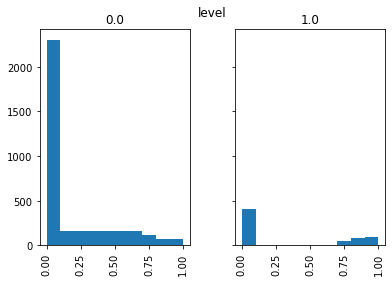

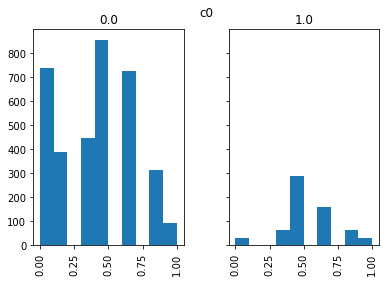

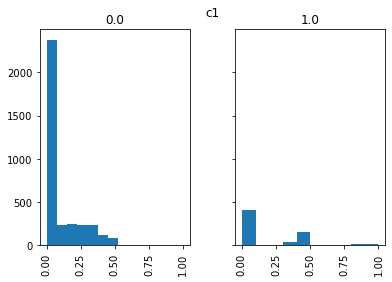

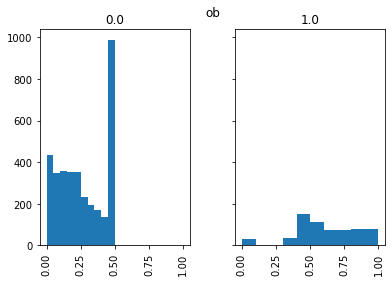

----------------1-----------------


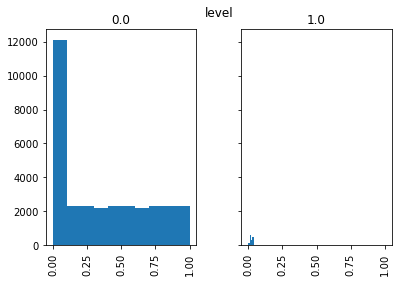

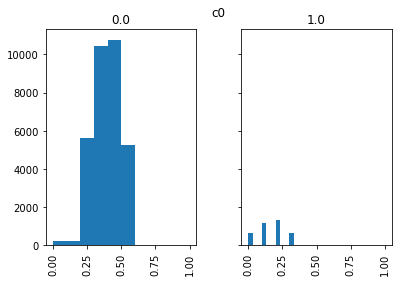

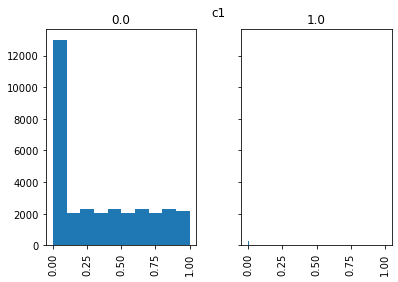

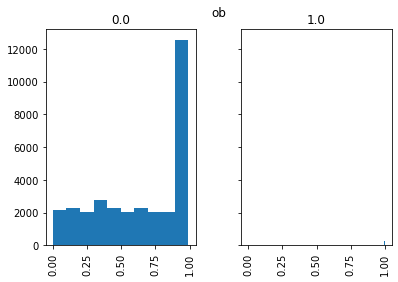

----------------2-----------------


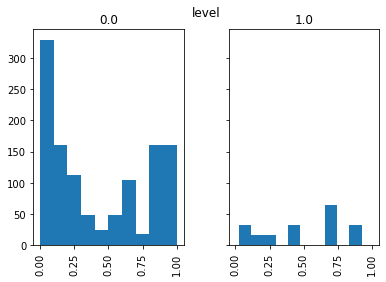

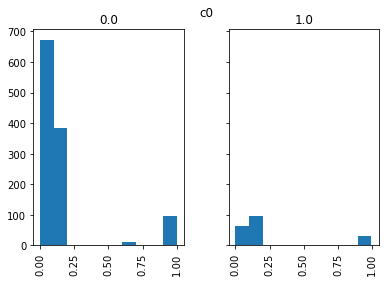

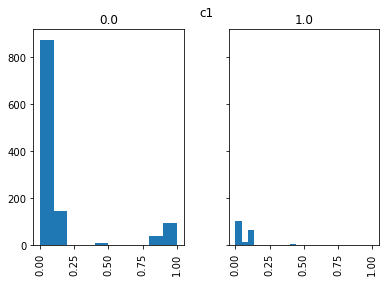

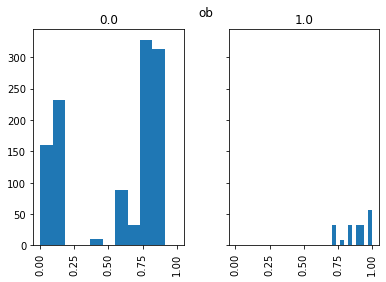

----------------3-----------------


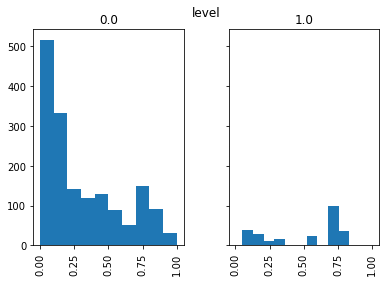

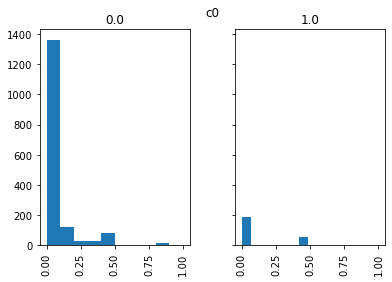

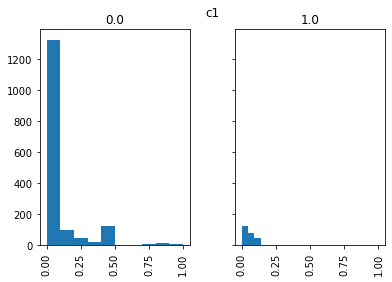

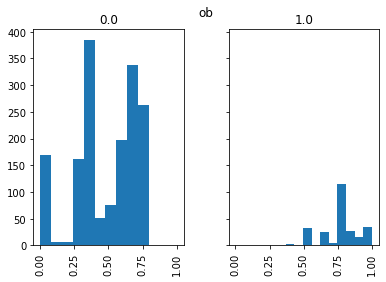

----------------4-----------------


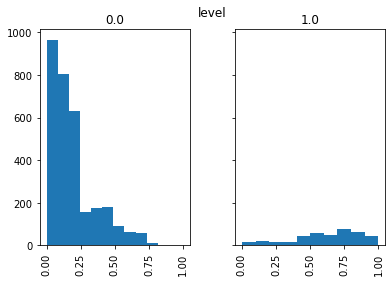

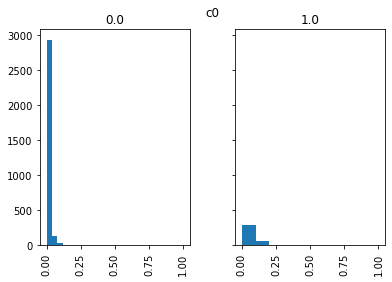

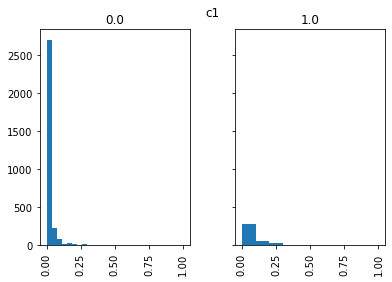

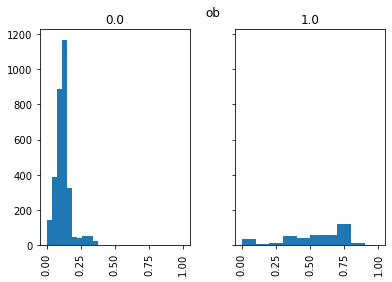

----------------5-----------------


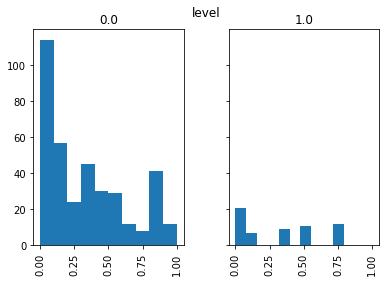

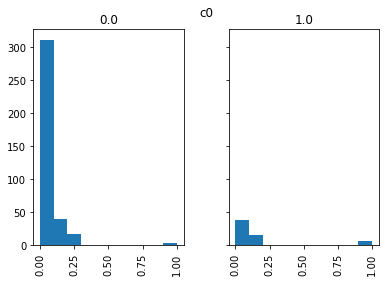

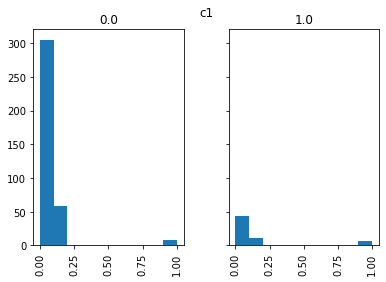

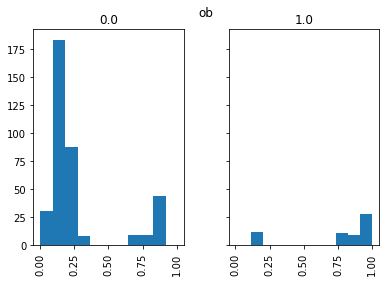

----------------6-----------------


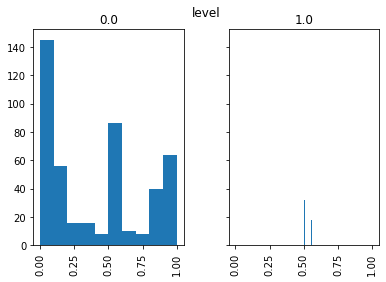

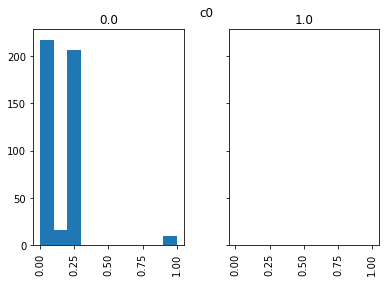

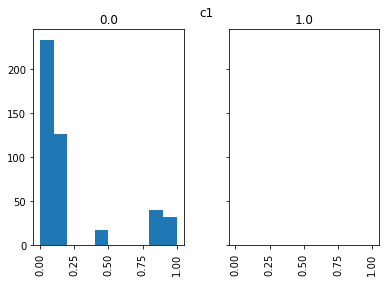

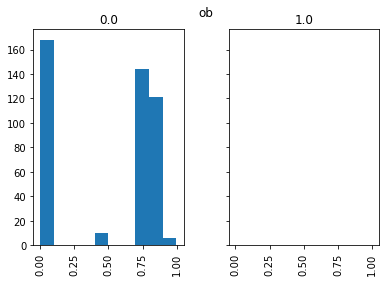

----------------7-----------------


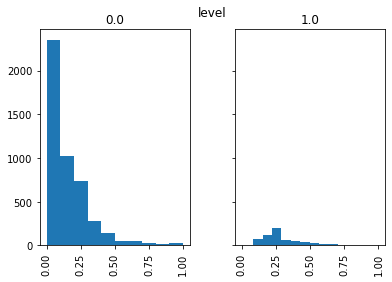

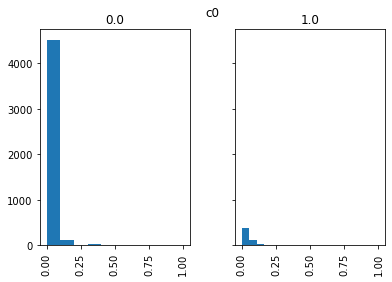

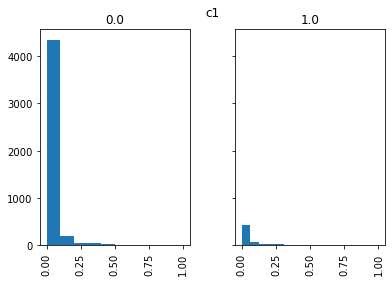

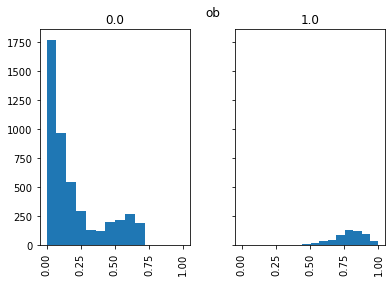

----------------8-----------------


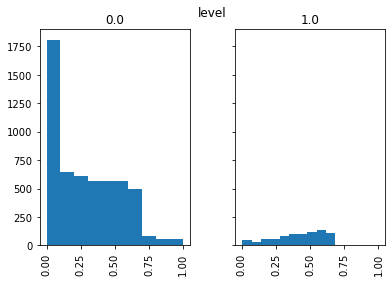

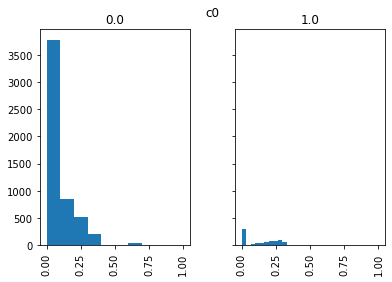

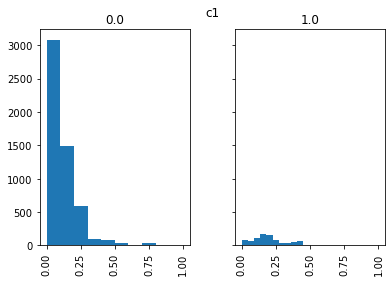

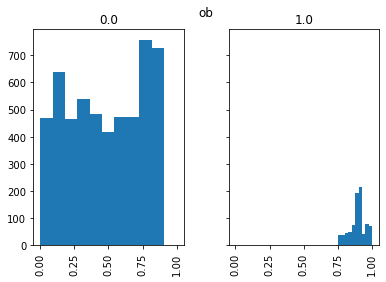

----------------9-----------------


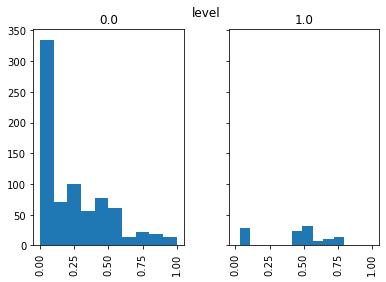

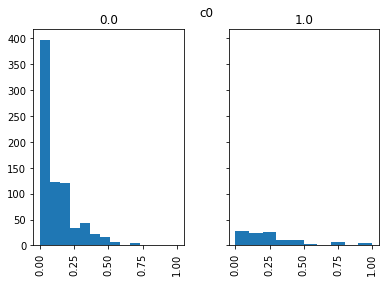

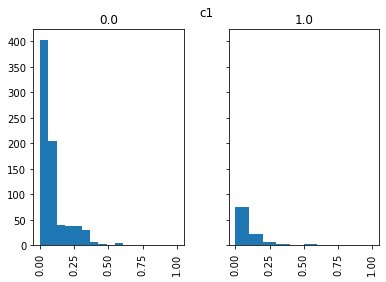

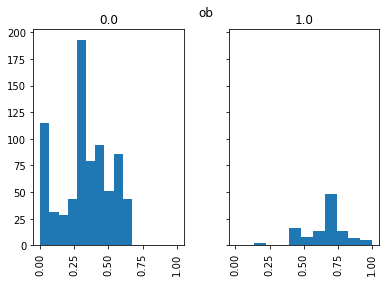

----------------10-----------------


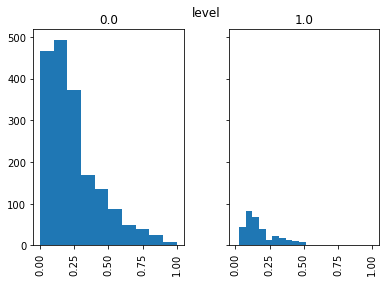

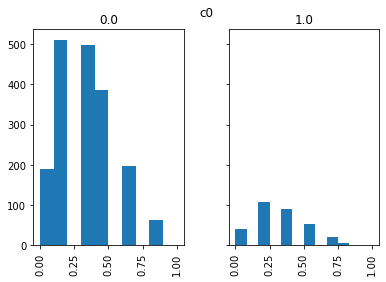

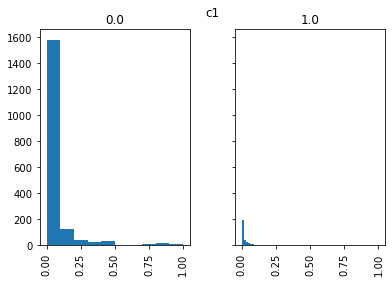

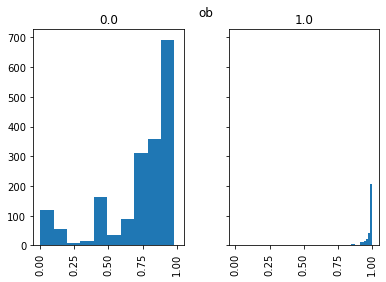

----------------11-----------------


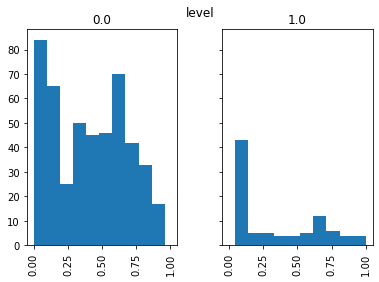

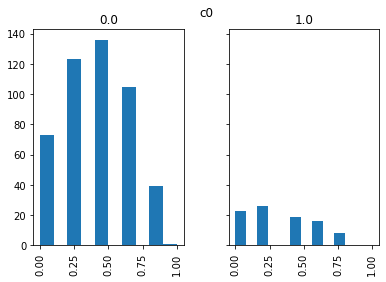

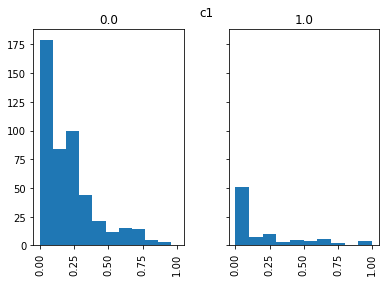

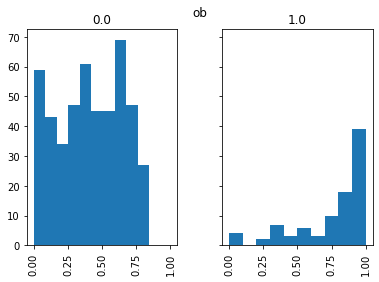

----------------12-----------------


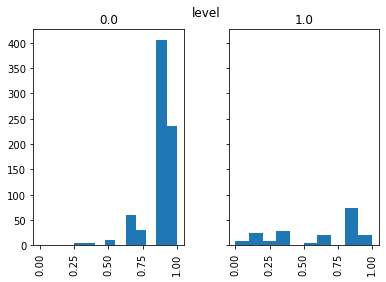

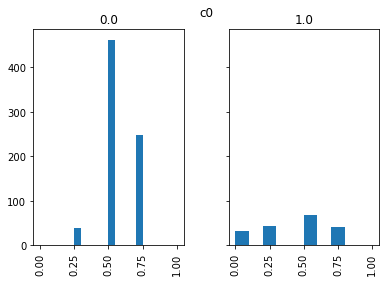

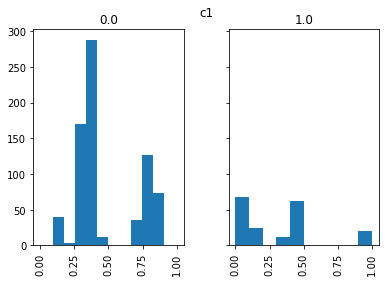

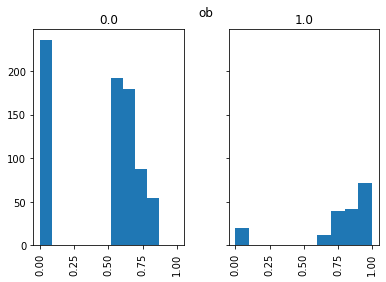

----------------13-----------------


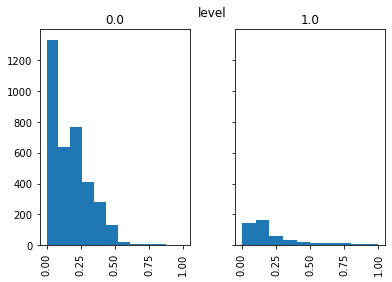

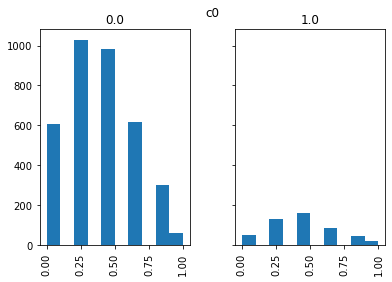

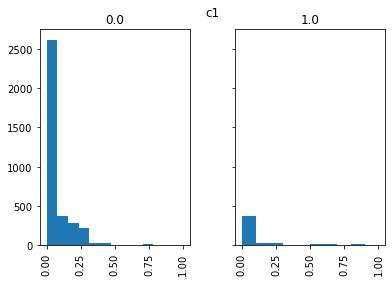

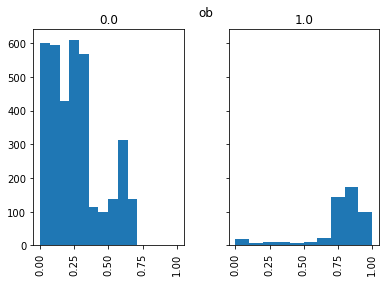

----------------14-----------------


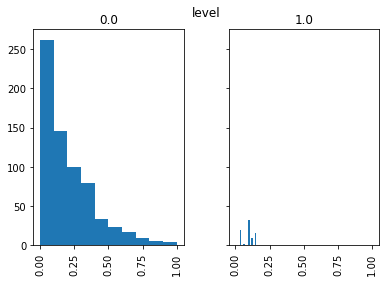

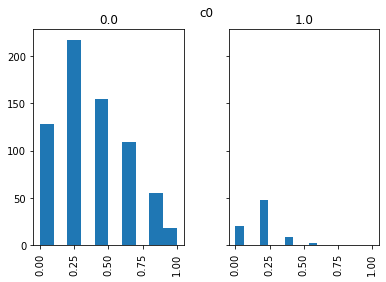

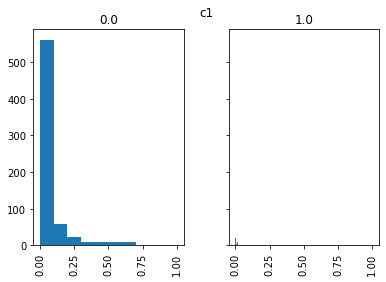

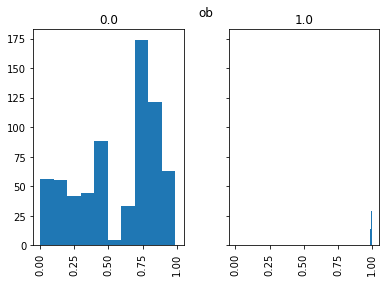

----------------15-----------------


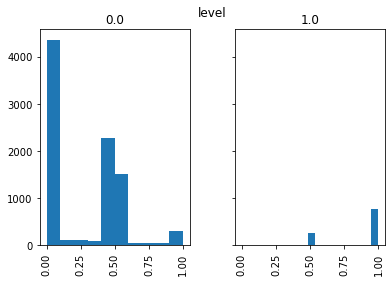

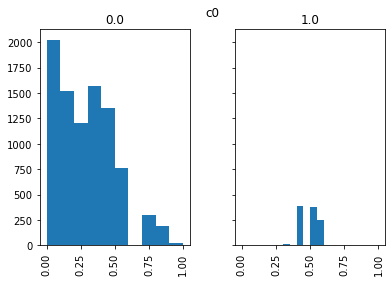

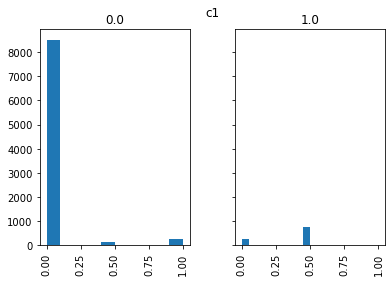

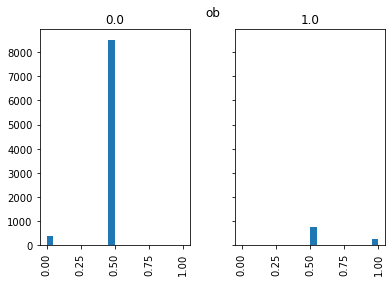

----------------16-----------------


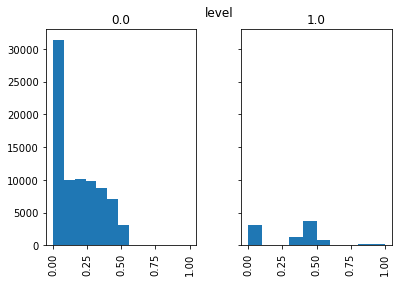

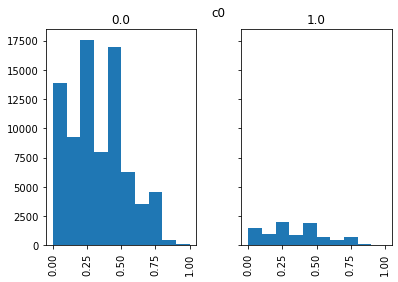

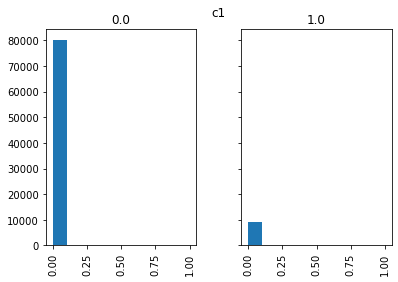

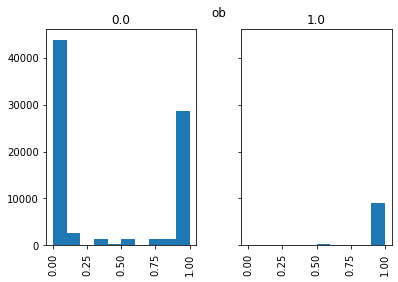

----------------17-----------------


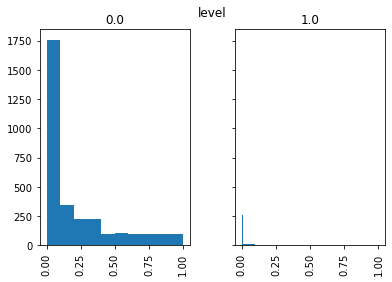

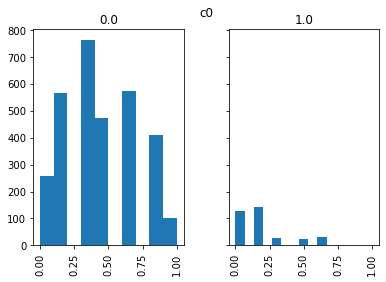

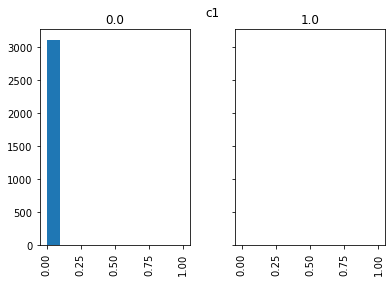

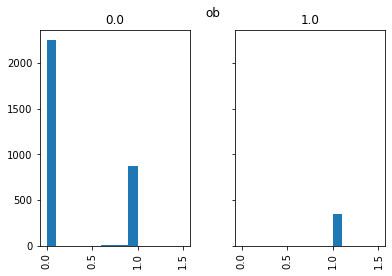

----------------18-----------------


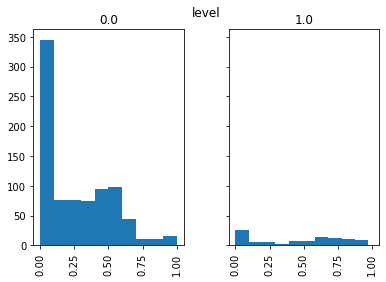

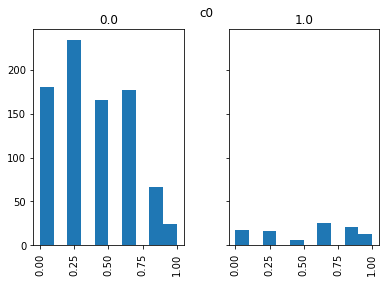

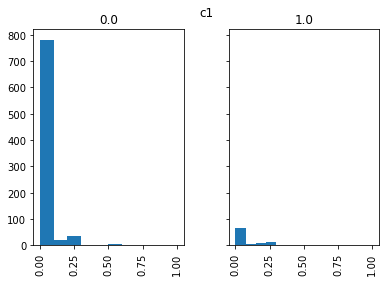

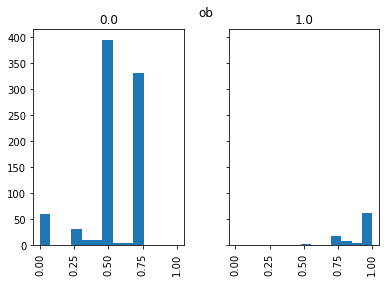

----------------19-----------------


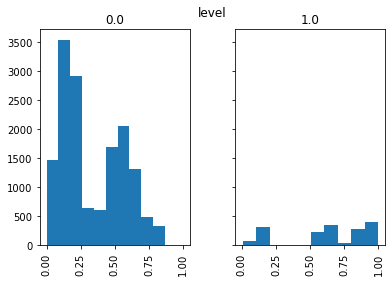

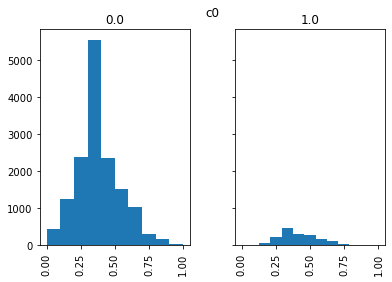

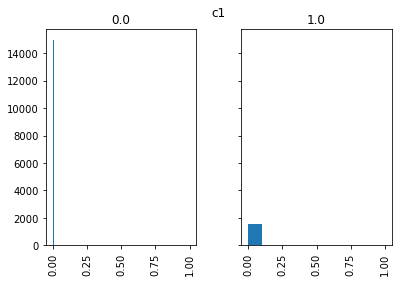

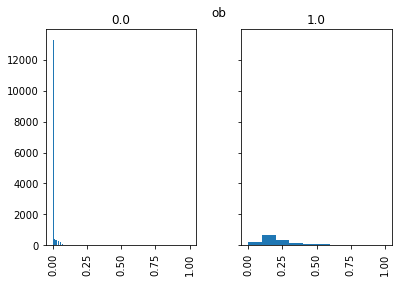

----------------20-----------------


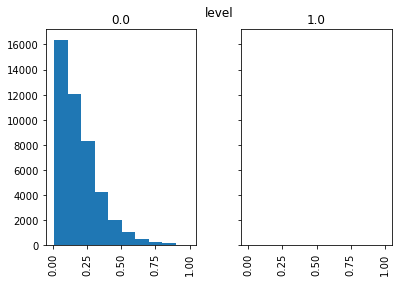

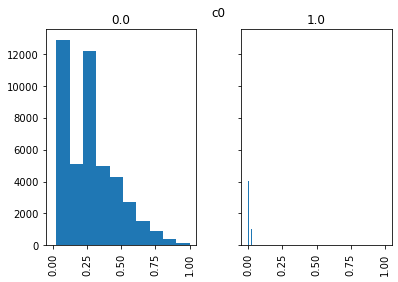

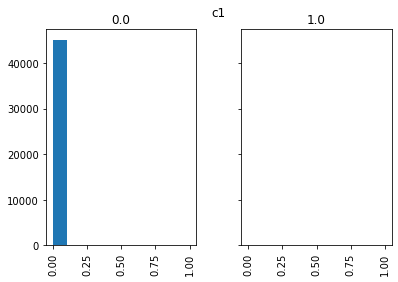

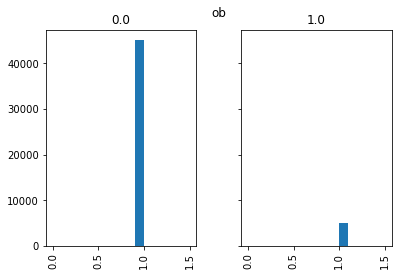

In [120]:
for i, g in enumerate(dataset):
    print(f"----------------{i}-----------------")
    df_all_circ_data = pd.DataFrame(g.x, columns=['level', 'c0', 'c1', 'ob'])
    df_all_circ_data['y'] = g.y
    for col in ['level', 'c0', 'c1', 'ob']:
        df_all_circ_data.hist(by='y', column=col, sharex=True, sharey=True)
        plt.suptitle(col)
        plt.show()

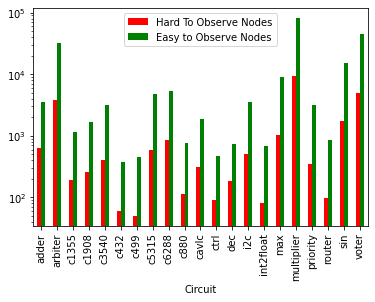

In [121]:
circs = ["adder","arbiter","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","ctrl","dec","i2c","int2float","max","multiplier","priority","router","sin","voter"]
table = []
for data, circ in zip(dataset, circs):
    table.append([circ.replace('.bench', ''), data.n_nodes - int(sum(data.y)[0]), int(sum(data.y)[0])])
data_nodes = pd.DataFrame(table, columns=['Circuit', "Easy to Observe Nodes", "Hard To Observe Nodes"])
index = data_nodes['Circuit']
ax = data_nodes.plot.bar('Circuit', ['Hard To Observe Nodes','Easy to Observe Nodes'], stacked=False, logy=True, color=['red', 'green'])


In [7]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

240587

# Compute class weight for unbalanced labels

In [8]:
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
print(weights)

{0.0: 0.5594349389003626, 1.0: 4.706280087527352}


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
%load_ext tensorboard

# Topology Aware Graph Convolution Network Model (TAGConv)

In [10]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers

channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 1e-4           # L2 regularization rate
learning_rate = 1e-5    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 10    
patience = 30 # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
mask_in = Input((None, ))

use_bias = True
x = TAGConv(channels, K=10, aggregate="sum",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="tagconv1")([X_in, fltr_in]) 
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = TAGConv(channels, K=10, aggregate="sum",
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="tagconv2")([x, fltr_in]) 
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x1 = TAGConv(256, k = 5, aggregate="mean",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="tagconv3")([x, fltr_in])
x = GraphSageConv(256, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="graphconv1")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
# x = GraphSageConv(256, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="graphconv2")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
x2 = GraphSageConv(256, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="graphconv3")([x, fltr_in])
concatted = tf.keras.layers.Concatenate()([x1, x2])
flattened = tf.keras.layers.Flatten()(concatted)
fl1 = tf.keras.layers.Dense(128, activation='relu')(flattened)
x = Dropout(dropout)(fl1)
x = tf.keras.layers.Dense(n_out, activation='sigmoid', name="classification")(x)
# x = GCNConv(n_out, activation='sigmoid',
#                          n_input_channels=dataset.n_node_features, name="classification", use_bias=use_bias)([x, fltr_in])

model = Model(inputs=[X_in, fltr_in, mask_in], outputs=x)
optimizer = Adam(lr=learning_rate)

def masked_loss_and_accuracy(target, predictions):
    loss = binary_crossentropy(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

    return (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

import tempfile
tfcallback_dir = tempfile.TemporaryDirectory(suffix='tf', prefix='', dir=None).name
tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir=tfcallback_dir,
        histogram_freq=1
)
# 
callback_GCN = [tbCallBack_GCN, EarlyStopping(patience=patience, restore_best_weights=True)]

X_in:  (None, 4)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
tagconv1 (TAGConv)              (None, 256)          11520       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graphconv1 (GraphSageConv)      (None, 256)          2304        input_1[0][0

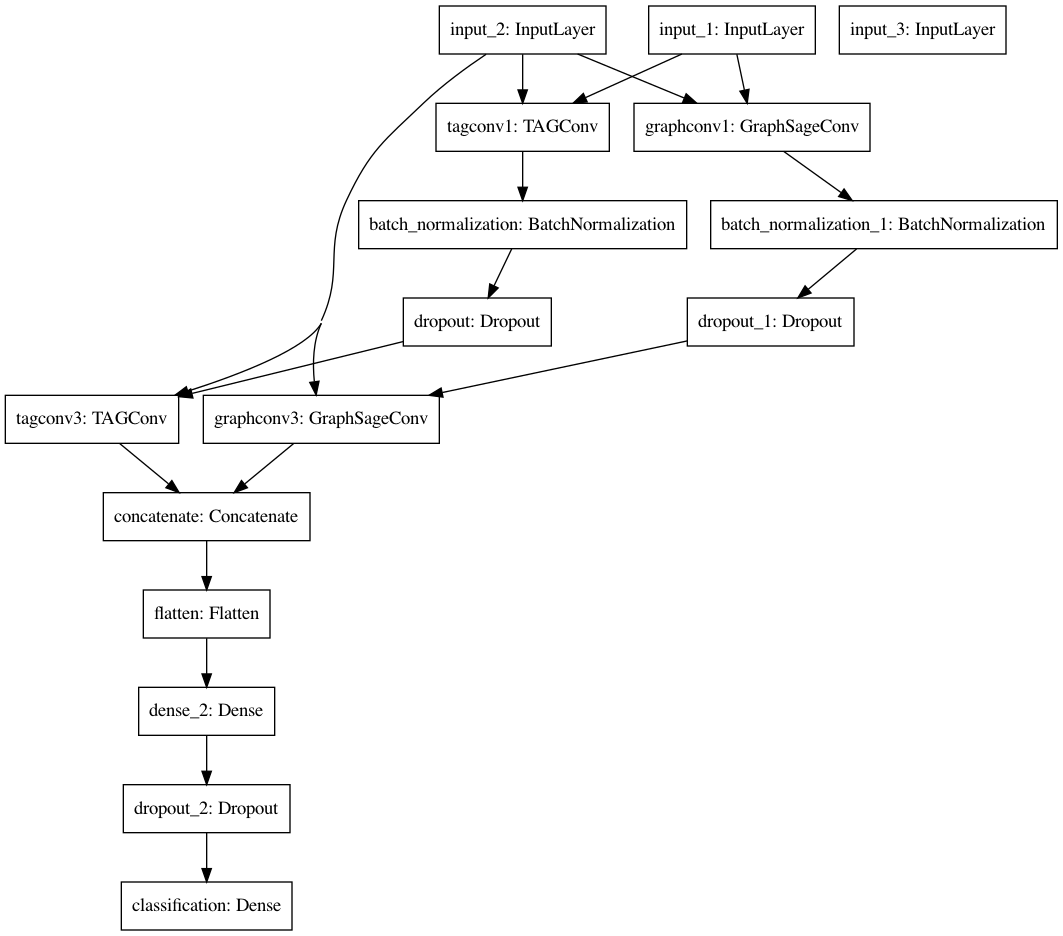

In [11]:
tf.keras.utils.plot_model(
    model,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
)

# Train the model

In [12]:
epochs = 500
loader_tr, loader_va, loader_te = load_tr_data(epochs)
# class_weight = {0: 0.11, 1: 0.89}
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    class_weight=weights,
    callbacks=callback_GCN
)

Epoch 1/500
6/6 [==============================] - 17s 2s/step - loss: 0.7882 - acc: 0.4789 - precision: 0.4829 - recall: 0.7409 - val_loss: 0.7802 - val_acc: 0.5798 - val_precision: 0.2259 - val_recall: 1.0000
Epoch 2/500
6/6 [==============================] - 15s 570ms/step - loss: 0.7802 - acc: 0.5169 - precision: 0.5081 - recall: 0.8583 - val_loss: 0.7805 - val_acc: 0.5874 - val_precision: 0.2291 - val_recall: 1.0000
Epoch 3/500
6/6 [==============================] - 11s 1s/step - loss: 0.7859 - acc: 0.5570 - precision: 0.5328 - recall: 0.9072 - val_loss: 0.7810 - val_acc: 0.5890 - val_precision: 0.2298 - val_recall: 1.0000
Epoch 4/500
6/6 [==============================] - 8s 2s/step - loss: 0.7625 - acc: 0.5854 - precision: 0.5543 - recall: 0.8729 - val_loss: 0.7812 - val_acc: 0.5918 - val_precision: 0.2310 - val_recall: 1.0000
Epoch 5/500
6/6 [==============================] - 8s 2s/step - loss: 0.7450 - acc: 0.6422 - precision: 0.5910 - recall: 0.9492 - val_loss: 0.7816 - val_a

Epoch 40/500
6/6 [==============================] - 7s 1s/step - loss: 0.6468 - acc: 0.6891 - precision: 0.6341 - recall: 0.9120 - val_loss: 0.7038 - val_acc: 0.7326 - val_precision: 0.3086 - val_recall: 0.9520
Epoch 41/500
6/6 [==============================] - 7s 1s/step - loss: 0.6164 - acc: 0.7397 - precision: 0.6746 - recall: 0.9480 - val_loss: 0.6992 - val_acc: 0.7366 - val_precision: 0.3119 - val_recall: 0.9520
Epoch 42/500
6/6 [==============================] - 7s 770ms/step - loss: 0.6041 - acc: 0.7705 - precision: 0.6985 - recall: 0.9507 - val_loss: 0.6945 - val_acc: 0.7425 - val_precision: 0.3165 - val_recall: 0.9487
Epoch 43/500
6/6 [==============================] - 7s 1s/step - loss: 0.6191 - acc: 0.7484 - precision: 0.6862 - recall: 0.9313 - val_loss: 0.6912 - val_acc: 0.7442 - val_precision: 0.3180 - val_recall: 0.9487
Epoch 44/500
6/6 [==============================] - 7s 1s/step - loss: 0.6329 - acc: 0.7094 - precision: 0.6516 - recall: 0.8939 - val_loss: 0.6879 - val

Epoch 79/500
6/6 [==============================] - 11s 594ms/step - loss: 0.5783 - acc: 0.7431 - precision: 0.6693 - recall: 0.9556 - val_loss: 0.5444 - val_acc: 0.7910 - val_precision: 0.3665 - val_recall: 0.9673
Epoch 80/500
6/6 [==============================] - 7s 1s/step - loss: 0.5517 - acc: 0.7838 - precision: 0.7114 - recall: 0.9529 - val_loss: 0.5390 - val_acc: 0.7961 - val_precision: 0.3722 - val_recall: 0.9651
Epoch 81/500
6/6 [==============================] - 10s 2s/step - loss: 0.5823 - acc: 0.7745 - precision: 0.7180 - recall: 0.9259 - val_loss: 0.5367 - val_acc: 0.7944 - val_precision: 0.3702 - val_recall: 0.9662
Epoch 82/500
6/6 [==============================] - 7s 1s/step - loss: 0.5771 - acc: 0.7731 - precision: 0.7273 - recall: 0.8719 - val_loss: 0.5346 - val_acc: 0.7949 - val_precision: 0.3710 - val_recall: 0.9673
Epoch 83/500
6/6 [==============================] - 7s 1s/step - loss: 0.5560 - acc: 0.7910 - precision: 0.7241 - recall: 0.9374 - val_loss: 0.5298 - v

Epoch 118/500
6/6 [==============================] - 7s 1s/step - loss: 0.5098 - acc: 0.8273 - precision: 0.7772 - recall: 0.9221 - val_loss: 0.4400 - val_acc: 0.8215 - val_precision: 0.4044 - val_recall: 0.9640
Epoch 119/500
6/6 [==============================] - 9s 2s/step - loss: 0.4971 - acc: 0.8561 - precision: 0.7954 - recall: 0.9712 - val_loss: 0.4383 - val_acc: 0.8222 - val_precision: 0.4051 - val_recall: 0.9618
Epoch 120/500
6/6 [==============================] - 9s 2s/step - loss: 0.5123 - acc: 0.8177 - precision: 0.7553 - recall: 0.9437 - val_loss: 0.4352 - val_acc: 0.8243 - val_precision: 0.4081 - val_recall: 0.9618
Epoch 121/500
6/6 [==============================] - 8s 844ms/step - loss: 0.5114 - acc: 0.8217 - precision: 0.7525 - recall: 0.9648 - val_loss: 0.4318 - val_acc: 0.8267 - val_precision: 0.4112 - val_recall: 0.9564
Epoch 122/500
6/6 [==============================] - 9s 1s/step - loss: 0.5065 - acc: 0.8689 - precision: 0.8323 - recall: 0.9292 - val_loss: 0.4290 

6/6 [==============================] - 9s 2s/step - loss: 0.4699 - acc: 0.8622 - precision: 0.8071 - recall: 0.9629 - val_loss: 0.4071 - val_acc: 0.8285 - val_precision: 0.4088 - val_recall: 0.8942
Epoch 157/500
6/6 [==============================] - 8s 812ms/step - loss: 0.4876 - acc: 0.8295 - precision: 0.7603 - recall: 0.9647 - val_loss: 0.4043 - val_acc: 0.8303 - val_precision: 0.4111 - val_recall: 0.8877
Epoch 158/500
6/6 [==============================] - 8s 1s/step - loss: 0.4637 - acc: 0.8582 - precision: 0.8127 - recall: 0.9325 - val_loss: 0.4050 - val_acc: 0.8291 - val_precision: 0.4102 - val_recall: 0.8997
Epoch 159/500
6/6 [==============================] - 10s 2s/step - loss: 0.4842 - acc: 0.8180 - precision: 0.7528 - recall: 0.9667 - val_loss: 0.4056 - val_acc: 0.8286 - val_precision: 0.4100 - val_recall: 0.9062
Epoch 160/500
6/6 [==============================] - 11s 2s/step - loss: 0.5057 - acc: 0.8225 - precision: 0.7561 - recall: 0.9716 - val_loss: 0.4058 - val_acc: 0

6/6 [==============================] - 14s 3s/step - loss: 0.4293 - acc: 0.8773 - precision: 0.8350 - recall: 0.9486 - val_loss: 0.3891 - val_acc: 0.8222 - val_precision: 0.3862 - val_recall: 0.7644
Epoch 195/500
6/6 [==============================] - 12s 2s/step - loss: 0.4512 - acc: 0.8830 - precision: 0.8598 - recall: 0.9193 - val_loss: 0.3870 - val_acc: 0.8230 - val_precision: 0.3861 - val_recall: 0.7525
Epoch 196/500
6/6 [==============================] - 16s 3s/step - loss: 0.4407 - acc: 0.8744 - precision: 0.8316 - recall: 0.9429 - val_loss: 0.3867 - val_acc: 0.8232 - val_precision: 0.3864 - val_recall: 0.7514
Epoch 197/500
6/6 [==============================] - 11s 2s/step - loss: 0.4260 - acc: 0.8870 - precision: 0.8516 - recall: 0.9441 - val_loss: 0.3869 - val_acc: 0.8246 - val_precision: 0.3901 - val_recall: 0.7644
Epoch 198/500
6/6 [==============================] - 8s 2s/step - loss: 0.4498 - acc: 0.8556 - precision: 0.8224 - recall: 0.9099 - val_loss: 0.3861 - val_acc: 0.

Epoch 233/500
6/6 [==============================] - 8s 1s/step - loss: 0.4555 - acc: 0.8710 - precision: 0.8444 - recall: 0.9192 - val_loss: 0.3667 - val_acc: 0.8315 - val_precision: 0.3952 - val_recall: 0.7056
Epoch 234/500
6/6 [==============================] - 11s 2s/step - loss: 0.4945 - acc: 0.8045 - precision: 0.7625 - recall: 0.9054 - val_loss: 0.3651 - val_acc: 0.8325 - val_precision: 0.3954 - val_recall: 0.6925
Epoch 235/500
6/6 [==============================] - 8s 1s/step - loss: 0.3964 - acc: 0.8920 - precision: 0.8509 - recall: 0.9574 - val_loss: 0.3639 - val_acc: 0.8346 - val_precision: 0.3989 - val_recall: 0.6881
Epoch 236/500
6/6 [==============================] - 7s 1s/step - loss: 0.4389 - acc: 0.8531 - precision: 0.7975 - recall: 0.9461 - val_loss: 0.3614 - val_acc: 0.8355 - val_precision: 0.3992 - val_recall: 0.6761
Epoch 237/500
6/6 [==============================] - 7s 825ms/step - loss: 0.4602 - acc: 0.8353 - precision: 0.7792 - recall: 0.9384 - val_loss: 0.3600

6/6 [==============================] - 8s 2s/step - loss: 0.3980 - acc: 0.8865 - precision: 0.8533 - recall: 0.9426 - val_loss: 0.3604 - val_acc: 0.8347 - val_precision: 0.4042 - val_recall: 0.7339
Epoch 272/500
6/6 [==============================] - 8s 1s/step - loss: 0.3955 - acc: 0.8757 - precision: 0.8300 - recall: 0.9455 - val_loss: 0.3621 - val_acc: 0.8327 - val_precision: 0.4020 - val_recall: 0.7470
Epoch 273/500
6/6 [==============================] - 8s 1s/step - loss: 0.4115 - acc: 0.8663 - precision: 0.8294 - recall: 0.9311 - val_loss: 0.3608 - val_acc: 0.8343 - val_precision: 0.4044 - val_recall: 0.7426
Epoch 274/500
6/6 [==============================] - 7s 1s/step - loss: 0.4305 - acc: 0.8508 - precision: 0.8046 - recall: 0.9302 - val_loss: 0.3567 - val_acc: 0.8394 - val_precision: 0.4131 - val_recall: 0.7361
Epoch 275/500
6/6 [==============================] - 7s 791ms/step - loss: 0.4238 - acc: 0.8572 - precision: 0.8060 - recall: 0.9416 - val_loss: 0.3560 - val_acc: 0.8

In [13]:
import os
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [83]:
%tensorboard --logdir {tfcallback_dir}

In [15]:
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))

1/1 [==============================] - 0s 225ms/step - loss: 0.3918 - acc: 0.8988 - precision: 0.5255 - recall: 0.1554
Done. Test loss: [0.39180445671081543, 0.898785412311554, 0.525547444820404, 0.15542364120483398]


# Model prediction metrics

In [98]:
loader_test = DisjointLoader(dataset_te, batch_size=len(dataset_te), node_level=True)
inputs, y_test = loader_test.__next__()
X_test, A_test, _ = inputs

from sklearn.metrics import classification_report
# print(len(dataset_te))
# for test_data in dataset_te:
#     X_te = test_data.x
#     A_te = test_data.a
#     y_te = test_data.y

y_pred = model.predict([X_test, A_test, A_test], batch_size=X_test.shape[0])
report = classification_report(y_test, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.95     16178
         1.0       0.53      0.16      0.24      1853

    accuracy                           0.90     18031
   macro avg       0.72      0.57      0.59     18031
weighted avg       0.87      0.90      0.87     18031



# Model layers output using TSNE

In [116]:
from sklearn.manifold import TSNE
test_data = dataset_te[1]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

# loader_test = DisjointLoader(dataset_te, batch_size=len(dataset_te), node_level=True)
# inputs, y_test = loader_test.__next__()
# X_test, A_test, ind_test = inputs

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict([X_test,A_test, ind_test],batch_size=X_test.shape[0])
activations = activation_model.predict([X_te,A_te, A_te],batch_size=X_te.shape[0])


In [117]:
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_classes = 2
def plot_tSNE(labels_encoded,x_tsne):
    color_map = labels_encoded
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl, alpha=0.5)
    plt.legend()
    plt.show()

11 flatten


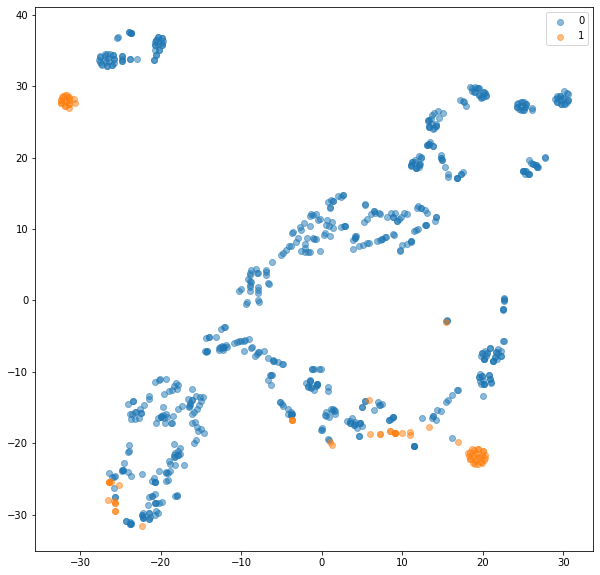

In [119]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
for i, layer in enumerate(model.layers):
#     if isinstance(layer, TAGConv) or isinstance(layer, GraphSageConv) or isinstance(layer, Dense) or isinstance(layer, Flatten):
    if isinstance(layer, Flatten):
        print(i, layer.name)
        x_tsne17 = TSNE(n_components=2).fit_transform(activations[i]) 
        plot_tSNE(y_te,x_tsne17)

# Metrics

In [95]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    precision = cnf_matrix[1,1]/cnf_matrix[:,1].sum()
    recall = cnf_matrix[1,1]/cnf_matrix[1,:].sum()
    print('precision:', precision)
    print('recall:', recall)
    if normalize:
#         cnf_matrix = confusion_matrix
        print("Normalized confusion matrix")

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [99]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test_list, predicted_labels_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()
    
    

### Confusion matrix for test data

precision: 0.5255474452554745
recall: 0.15542363734484618


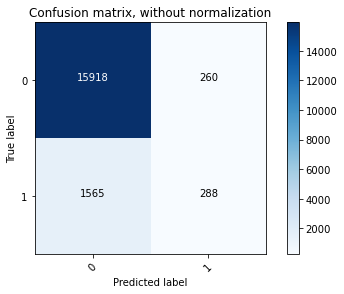

In [100]:
from sklearn.metrics import classification_report
import itertools

class_names = ['0', '1']
report = plot_confusion_matrix(y_test, (y_pred >= 0.5).astype(int))


In [101]:
y_train = []
X_train =[]
A_train = []
for data_tr in dataset_tr:
    y_train.append(data_tr.y)
    X_train.append(data_tr.x)
    A_train.append(dataset_tr.a)
y_train = np.vstack((y_train)).reshape((-1,))
X_train = np.vstack((X_train))
A_train = np.vstack((A_train))
X_train.shape
y_train.shape
A_train.shape


y_test = []
X_test =[]
A_test = []
for data_tr in [dataset_te[1]]:
    y_test.append(data_tr.y)
    X_test.append(data_tr.x)
    A_test.append(dataset_tr.a)
y_test = np.vstack((y_test)).reshape((-1,))
X_test = np.vstack((X_test))
A_test = np.vstack((A_test))
X_test.shape
y_test.shape
A_test.shape

(1, 1)

In [102]:
loader_test = DisjointLoader(dataset_te, batch_size=len(dataset_te), node_level=True)
inputs, y_test = loader_test.__next__()
X_test, A_test, _ = inputs

### Precision Recall Curve

In [103]:
y_pred = model.predict([X_test, A_test, A_test], batch_size=X_test.shape[0])

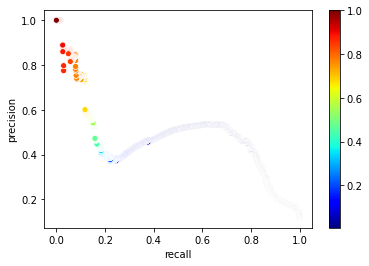

In [70]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_test, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='jet')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

### ROC curve for test data

In [104]:
from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

In [105]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

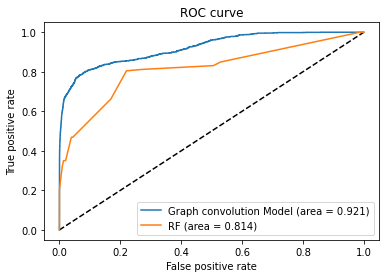

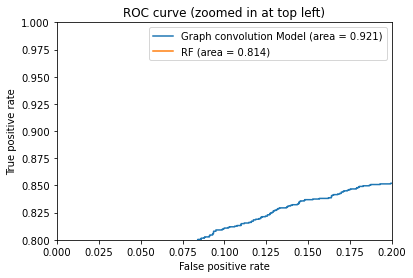

precision: 1.0
recall: 0.09170052234474753


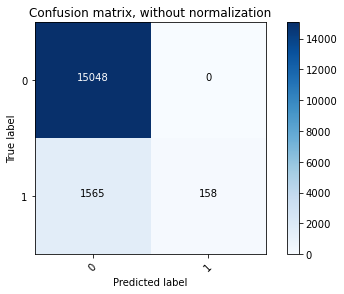

precision: nan
recall: 0.0


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


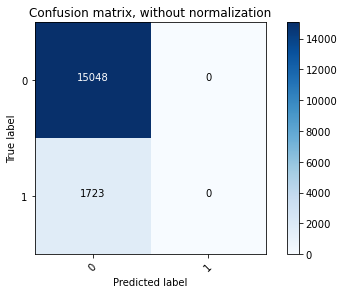

In [114]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

class_names = ['0', '1']
report = plot_confusion_matrix(y_test, (y_pred >= 0.5).astype(int))


report_1 =  plot_confusion_matrix(y_test, (y_pred_rf >= 0.5).astype(int))


### ROC curve and precision recall curve specific to circuit

#### Int to Float circuit

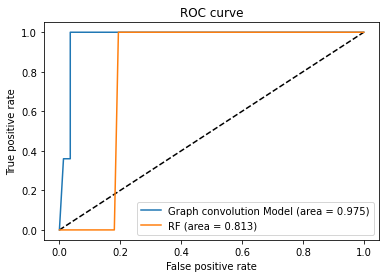

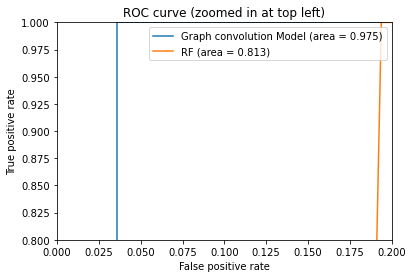

precision: 0.3067484662576687
recall: 1.0


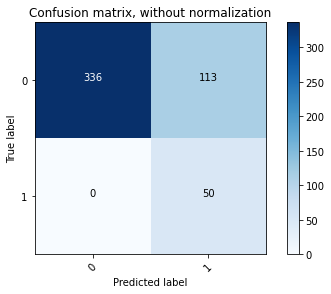

In [107]:
loader_test = DisjointLoader(dataset_te[0:1], batch_size=1, node_level=True)
inputs, y_test = loader_test.__next__()
X_test, A_test, _ = inputs
from sklearn.metrics import roc_curve, auc

y_pred = model.predict([X_test, A_test, A_test], batch_size=X_test.shape[0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

class_names = ['0', '1']
report = plot_confusion_matrix(y_test, (y_pred >= 0.5).astype(int))

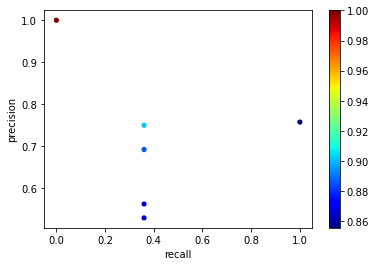

In [108]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_test, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='jet')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

#### Sin circuit

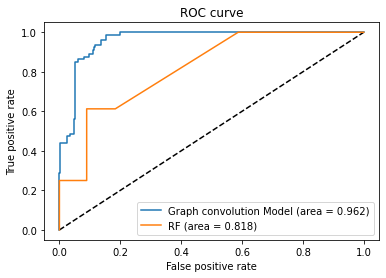

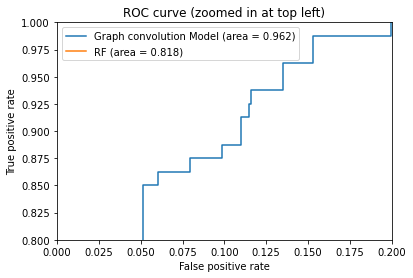

precision: 0.3524229074889868
recall: 1.0


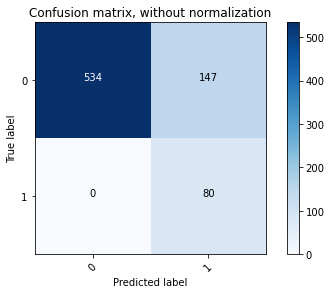

In [109]:
loader_test = DisjointLoader(dataset_te[1:2], batch_size=1, node_level=True)
inputs, y_test = loader_test.__next__()
X_test, A_test, _ = inputs
from sklearn.metrics import roc_curve, auc

y_pred = model.predict([X_test, A_test, A_test], batch_size=X_test.shape[0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

class_names = ['0', '1']
report = plot_confusion_matrix(y_test, (y_pred >= 0.5).astype(int))

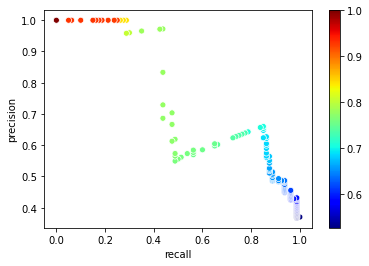

In [110]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_test, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='jet')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

#### c499 circuit

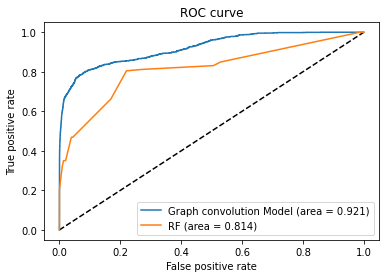

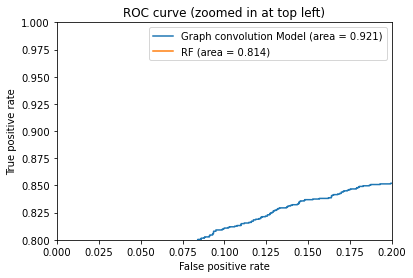

precision: 1.0
recall: 0.09170052234474753


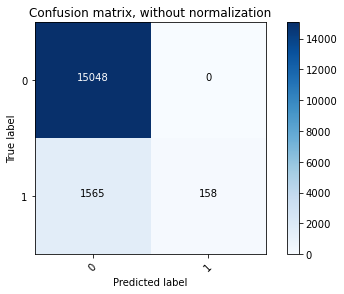

In [111]:
loader_test = DisjointLoader(dataset_te[2:], batch_size=1, node_level=True)
inputs, y_test = loader_test.__next__()
X_test, A_test, _ = inputs
from sklearn.metrics import roc_curve, auc

y_pred = model.predict([X_test, A_test, A_test], batch_size=X_test.shape[0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Graph convolution Model (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

class_names = ['0', '1']
report = plot_confusion_matrix(y_test, (y_pred >= 0.5).astype(int))

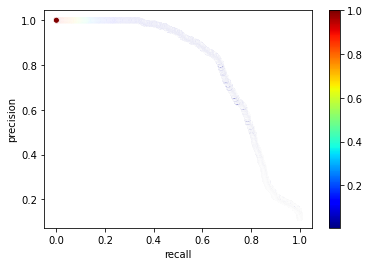

In [112]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_test, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='jet')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

# Conclusion

Precision is higher than recall for overall test data. However, both are less than 55%. But AUC ROC is at 88% which is considerably higher value. From ROC curve we see that this model performs better than base Random Forest Model. Looking at evaluation for individual circuits in test set as shown in Fig 15, we find that two test circuits have 100% recall while the third one has 100% precision. The ROC for all the test circuits are between 92 to 97%. However, for each circuit it would either have 100% recall or 100% recall but not a balanced combination of both. We saw this model was able to cluster the hard to observe nodes better than the other models. 